# Phase 2

## Motivation

My motivation for this project was the general understanding of how people's attention and worry concerning COVID has faded over time, despite the massive increase in cases. Upon thinking back to March it fascinates me how much people talked about COVID and how serious everyone took it, despite extremely low case numbers relative to today. Today it seems like many people have started to not worry about COVID or simply ignore it. I wanted to test if this was also true for our Boulder County and CU Boulder leaders. I thought this was interesting because it is important for our community leaders to set a good example for our city and to respond to massive increases in COVID cases with stronger pushes for safety guidelines. 

This led me to my research question: Have our Boulder County and CU leaders tweeted less about COVID as time has gone on and cases have increased?

To do this, as discussed and carried out in Phase 1, I gathered data from 15 different Boulder related Twitter accounts and determined how often they mentioned COVID and other related terms in their tweets. We will pick up in this notebook where we left off in Phase 1, focusing more on analysis and testing our hypothesis which is stated below.

## **Hypothesis**

My hypothesis is that there is a negative correlation between cases of COVID-19 and how often the virus is mentioned on twitter from our community leading people and organizations.

## Data Collection & Cleaning

In [1]:
import requests
import json

import pandas as pd
import numpy as np

pd.options.display.max_columns = 100

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

import datetime as datetime
import csv

Get COVID Data

In [2]:
req = requests.request('GET', 'https://opendata.arcgis.com/datasets/52fb11a8a07f49c1b28335a9de9ba99f_0.geojson')
response_json = json.loads(req.text)


In [3]:
list_of_dates = []
list_of_cases = []
for data in response_json["features"]:
    if data["properties"]["COUNTY"] == "BOULDER":
        if data["properties"]["Metric"] == "Cases":
            list_of_dates.append(data["properties"]["Date"])
            list_of_cases.append(data["properties"]["Value"])

In [4]:
boco_cases_df = pd.DataFrame({"Date": list_of_dates,
                             "Cases": list_of_cases})

In [5]:
boco_cases_df.drop(boco_cases_df.tail(6).index,inplace=True) #drop 6 days of december

In [6]:
boco_cases_df["Date"] = pd.to_datetime(boco_cases_df["Date"])
boco_cases_df.head()

,Date,Cases
0,2020-03-25,51
1,2020-03-23,39
2,2020-03-21,30
3,2020-03-24,49
4,2020-03-20,16


Load Twitter Data from Phase 1

In [7]:
load_new_boulder_tweets = pd.read_csv("complete_boulder_tweets.csv")
load_new_boulder_tweets.head()

,User,Month,Number of Covid Mentions,Total Tweets,Mentions Per Tweet
0,CUBoulder,1,4,191,0.020942
1,CUBoulder,2,1,238,0.004202
2,CUBoulder,3,50,351,0.142450
3,CUBoulder,4,40,317,0.126183
4,CUBoulder,5,24,323,0.074303


Merge Data

In [8]:
boco_gb = boco_cases_df.copy()
boco_gb["Month"] = boco_gb["Date"].apply(lambda x: x.month)
boco_gb_mean = boco_gb.groupby("Month").agg({"Cases":"mean"})
boco_gb_total = boco_gb.groupby("Month").agg({"Cases":"sum"})

boco_gb_mean.reset_index(inplace=True)
boco_gb_total.reset_index(inplace=True)

In [9]:
jan = pd.DataFrame({"Month":datetime.datetime(1,1,20).month,"Cases":0},index =[0])
feb = pd.DataFrame({"Month":datetime.datetime(2,2,20).month,"Cases":0},index =[1])

boco_gb_mean = pd.concat([jan,feb,boco_gb_mean]).reset_index(drop=True)
boco_gb_total = pd.concat([jan,feb,boco_gb_total]).reset_index(drop=True)

boco_gb_covid = boco_gb_mean.copy()

boco_gb_covid["Total Cases"] = boco_gb_total["Cases"]
boco_gb_covid.rename(columns={"Cases":"Average Cases"},inplace=True)

In [10]:
merged_df = load_new_boulder_tweets.merge(boco_gb_covid, on="Month")
merged_df["Average Cases"] = merged_df["Average Cases"].shift(1)
merged_df["Total Cases"] = merged_df["Total Cases"].shift(1)
merged_df.fillna(0,inplace=True)
merged_df.drop(columns=["Month"],inplace=True)

Add a Month column

In [11]:
months = []
count = 1
for i in range(0,11):
    for b in range(0,15):
        months.append(count)
    count+=1
len(months)

merged_df["Month"] = [item for item in months]

In [12]:
merged_df["Total Cases"] = merged_df["Total Cases"].shift(-1)
merged_df.loc[164,"Total Cases"] = merged_df.loc[163,"Total Cases"]
merged_df["Average Cases"] = merged_df["Average Cases"].shift(-1)
merged_df.loc[164,"Average Cases"] = merged_df.loc[163,"Average Cases"]

In [13]:
merged_df.head()

,User,Number of Covid Mentions,Total Tweets,Mentions Per Tweet,Average Cases,Total Cases,Month
0,CUBoulder,4,191,0.020942,0.0,0.0,1
1,CUMarkKennedy,4,41,0.097561,0.0,0.0,1
2,CUBoulderPolice,2,40,0.050000,0.0,0.0,1
3,CUBuffs,10,120,0.083333,0.0,0.0,1
4,CUBoulderLife,1,48,0.020833,0.0,0.0,1


In [91]:
merged_df.tail()

,User,Number of Covid Mentions,Total Tweets,Mentions Per Tweet,Average Cases,Total Cases,Month
160,BoulderChamber,34,128,0.265625,8472.7,254181.0,11
161,downtownboulder,1,34,0.029412,8472.7,254181.0,11
162,boulderparksrec,5,73,0.068493,8472.7,254181.0,11
163,ColoradoStateU,47,188,0.250000,8472.7,254181.0,11
164,GovofCO,15,21,0.714286,8472.7,254181.0,11


## Analysis

We can take many different approaches to test this hypothesis. 

Let's first start with the question: 

### In what month has each account tweeted about COVID the most?

In [14]:
total_list_of_accounts = [
    "CUBoulder",
    "CUMarkKennedy",
    "CUBoulderPolice",
    "CUBuffs",
    "CUBoulderLife",
    "bouldercounty",
    "bouldercohealth",
    "bouldernews",
    "bldrCOSheriff",
    "BoulderCh1News",
    "BoulderChamber",
    "downtownboulder",
    "boulderparksrec",
    "ColoradoStateU",
    "GovofCO"
]


list_of_users_dictionaries = []

for account in total_list_of_accounts:
    dictionary = {}
    users_df = merged_df[merged_df["User"]==account]
    top = users_df.sort_values("Mentions Per Tweet",ascending=False).head(3)
    list_of_values = []
    for value in top["Month"]:
        list_of_values.append(value)
    dictionary["User"] = account
    dictionary["Top Month"] = list_of_values[0]
    list_of_users_dictionaries.append(dictionary)
    
top_months = pd.DataFrame(list_of_users_dictionaries)

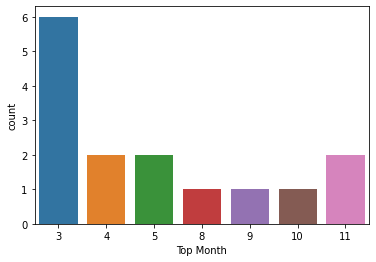

In [15]:
ax = sb.countplot(x="Top Month",data=top_months)

It appears that among all of our 15 twitter accounts analyzed, 6 of them tweeted the most about COVID in March. This is the most in a month by far, with April, May, and November tieing for second with 2 accounts each.

### How has each accounts' COVID mentions changed over time?

In [16]:
covid_mentions_pivot = pd.pivot_table(merged_df,
                                      index="User",
                                      columns="Month",
                                      values="Mentions Per Tweet"
                                     )


covid_mentions_pivot.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul',"Aug","Sep","Oct","Nov"]

Text(0.5, 1.0, 'Percentage of COVID Mentions Per Account Over Time')

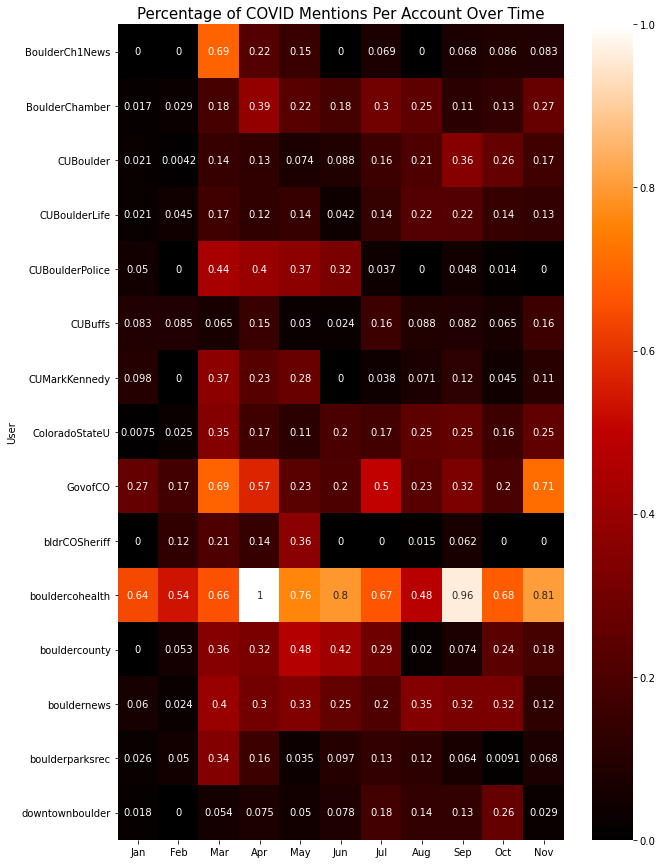

In [105]:
f,ax = plt.subplots(figsize=(10,15))
sb.heatmap(covid_mentions_pivot,ax=ax,annot=True,cmap="gist_heat")
ax.set_title("Percentage of COVID Mentions Per Account Over Time",fontsize=15)

To clarify, this heatmap is showing each accounts average COVID mentions per tweet, per month. For example, this means that in March @CUBoulder only had 14% of their tweets discussing COVID while @ColoradoStateU had 35% of their tweets in March discussing COVID. This shows us that CSU did a better job initially responding to the virus. However, CU did increase their mentions over time as the cases increased. 

Additionally, with this heatmap we see that most accounts have the highest percentage of tweets about COVID in March. We can see that @bouldercohealth has tweeted the most (and the most consistently) about COVID, which obviously is not surprising. 

### What is the average amount of tweets about COVID by month?

In [18]:
average_per_month = pd.DataFrame(covid_mentions_pivot.mean(axis=0))
average_per_month.columns = ["Average Per Month"]
average_per_month

,Average Per Month
Jan,0.087174
Feb,0.076765
Mar,0.340797
Apr,0.291841
May,0.242173
Jun,0.179721
Jul,0.202340
Aug,0.162017
Sep,0.212542
Oct,0.173860


<AxesSubplot:>

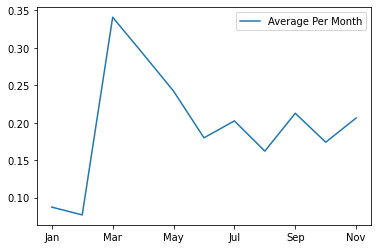

In [19]:
average_per_month.plot()

Here we see that across all 15 twitter accounts, March was by far had the highest percenatage of COVID tweets. Since March we have seen a solid decrease leading into the summer months and then slight upticks and downticks in the fall months.

### Correlations

Let's look at the correlations between covid cases and number of COVID mentions from each Twitter account.

In [50]:
def get_correlations_for_accounts(list_of_accounts):
    correlations_list = []
    for account in list_of_accounts:
        correlations = {}
        _df = merged_df[merged_df["User"]==account]
        correlations[account] = _df["Mentions Per Tweet"].corr(_df["Average Cases"])
        correlations_list.append(correlations)
    return(correlations_list)

In [61]:
correlations_df = pd.DataFrame.from_dict(correlations_list)


In [62]:
correlations_df = correlations_df.melt()
correlations_df.columns = ["User","Correlation"]
correlations_df.dropna(inplace=True)

In [63]:
correlations_df.reset_index(inplace=True)

In [84]:
less_than_zero = len(correlations_df[correlations_df["Correlation"]<0])

print("There are {} accounts of the 15 studied whose amount of monthly COVID mentions on Twitter are NEGATIVELY correlated with COVID cases.".format(less_than_zero))

There are 7 accounts of the 15 studied whose amount of monthly COVID mentions on Twitter are NEGATIVELY correlated with COVID cases.


In [88]:
more_than_zero = len(correlations_df[correlations_df["Correlation"]>0])

print("There are {} accounts of the 15 studied whose amount of monthly COVID mentions on Twitter are POSITIVELY correlated with COVID cases.".format(more_than_zero))

There are 8 accounts of the 15 studied whose amount of monthly COVID mentions on Twitter are POSITIVELY correlated with COVID cases.


Suprisingly it seems that the twitter accounts are split between tweeting more about COVID as cases increase and less as cases increase.

Are there any accounts with strong correlations?

In [75]:
correlations_df.sort_values("Correlation",ascending=False).head(5)[["User","Correlation"]]

,User,Correlation
0,CUBoulder,0.537932
3,CUBuffs,0.346185
13,ColoradoStateU,0.336116
4,CUBoulderLife,0.316295
11,downtownboulder,0.304579


These are twitter accounts who have tweeted more about COVID as cases have increased. 

At number one is @CUBoulder with a moderately strong correlation of 0.54. This makes sense because CU has begun pushing heavy safety guidelines as students have returned to school in the fall and as Boulder has seen an increase in cases. 

In my opinion this makes CU look responsible because they are rising to the challenge and concern of the spike in COVID case numbers. While obviously these are merely tweets, as an influential voice like @CUBoulder, it is better to get the word out and encourage safe behavior than to not.

In [76]:
correlations_df.sort_values("Correlation").head(5)[["User","Correlation"]]

,User,Correlation
2,CUBoulderPolice,-0.485481
8,bldrCOSheriff,-0.421276
12,boulderparksrec,-0.315880
1,CUMarkKennedy,-0.237522
9,BoulderCh1News,-0.215771


These are twitter accounts who may have tweeted about COVID a decent amount in March but as time has gone on (and cases have increased) they have tweeted about the virus less and less.

The two leaders of this category are @CUBoulderPolice and @bldrCOSheriff which tells us that law enforcement is not focusing on COVID, instead going back to their regular tweeting habits.

@CUMarkKennedy is in this list with a correlation of -0.24 which isn't super strong but this is surprising considering that @CUBoulder and @CUBuffs lead the list of most positively correlated accounts. 

### How does this data compare in relation to COVID-19 cases in Boulder County?

In [20]:
grouped_df = merged_df.groupby("Month").agg({"Number of Covid Mentions":sum,
                                            "Total Cases":"mean"})

In [21]:
# get rid of january and feburary
grouped_df = grouped_df.tail(9)

In [22]:
grouped_df["Normed Covid Mentions"] = grouped_df["Number of Covid Mentions"]/grouped_df.loc[3,"Number of Covid Mentions"]
grouped_df["Normed Cases"] = grouped_df["Total Cases"]/grouped_df.loc[3,"Total Cases"]

grouped_df

,Number of Covid Mentions,Total Cases,Normed Covid Mentions,Normed Cases
Month,,,,
3,495,771.0,1.000000,1.000000
4,318,9756.0,0.642424,12.653696
5,199,25586.0,0.402020,33.185473
6,142,34449.0,0.286869,44.680934
7,198,49712.0,0.400000,64.477302
8,245,65883.0,0.494949,85.451362
9,383,95681.0,0.773737,124.099870
10,319,155641.0,0.644444,201.869001
11,259,254181.0,0.523232,329.677043


Text(0, 0.5, 'Percentage Increase from March')

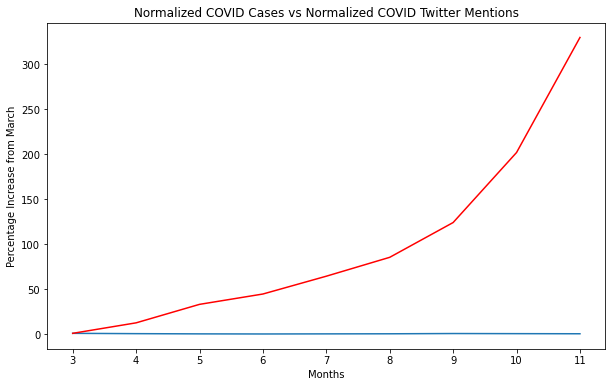

In [92]:
f, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(grouped_df["Normed Covid Mentions"])
ax1.plot(grouped_df["Normed Cases"],color="r")

plt.title('Normalized COVID Cases vs Normalized COVID Twitter Mentions')
plt.xlabel('Months')
plt.ylabel('Percentage Increase from March')


Even after normalizing our data this is how our graph turns out. This shows how massively cases have increased since March while mentions of COVID have not increased. This tells us that COVID cases have increased by over 300 percent since March while COVID mentions on Twitter have barely changed. 

Since this graph is more for shock factor of how much cases have increased and not for comparing the two variables. In the next graph we will add a secondary y-axis to better see how these variables relate.

Text(0, 0.5, 'Total COVID cases in Boulder County')

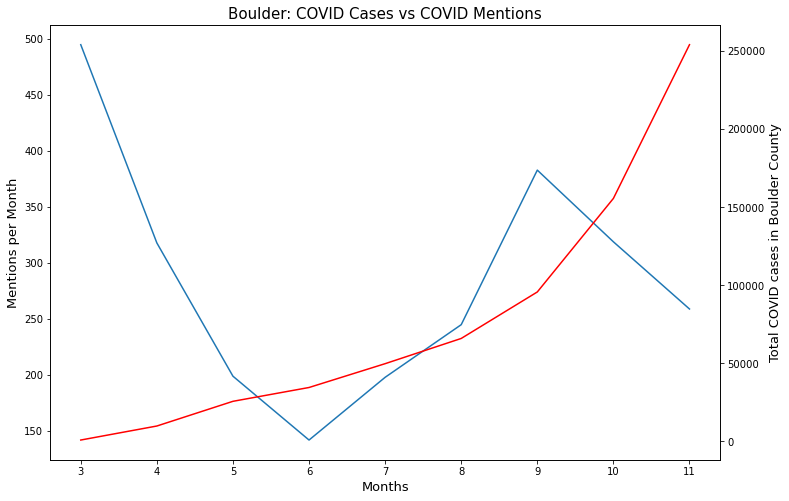

In [102]:
f, ax1 = plt.subplots(figsize=(12, 8))
plt.title('Boulder: COVID Cases vs COVID Mentions',fontsize=15)
plt.xlabel('Months',fontsize=13)
plt.ylabel('Mentions per Month',fontsize=13)

ax1.plot(grouped_df["Number of Covid Mentions"])

ax2 = ax1.twinx()
ax2.plot(grouped_df["Total Cases"],color="r")

plt.ylabel('Total COVID cases in Boulder County',fontsize=13)

This is the most important graph of this entire project.

Here we see in March that, relative to COVID cases, there was a massive amount of tweets regarding COVID from our CU Boulder and Boulder County leaders. Then as months went by our community leaders began to tweet less and less about the virus, reaching a low of only about 150 mentions in the month of June. 

In August and September our community leaders did an excellent job of responding to the increase in COVID cases with an increase of their tweets pushing for safe COVID guidelines. 

However, despite a massive spike of cases in October and November, our community leaders have dropped off in their tweeting about COVID.

This graph tells us that in the months of March, July, August, and September there was a positive correlation between COVID cases and the amount that Boulder was tweeting about COVID.

However, in the months of April, May, June, October, and November there was a negative correlation.

One would have hoped for this graph to consist of the blue line following the red line and preferably the blue line being higher than the red line, implying that Boulder was tweeting more than the relative number of COVID cases as they did in March. 


**Why does this matter?**

This matters because we need our Boulder County and CU Boulder leaders to provide a good example and promote COVID safety guidelines. Without this, our citizens are more likely to forget about the implications of the virus which in turn would lead to more positive cases and ultimately more deaths. 

While I understand that this only concerns raising awareness and pushing for safe habits and that tweets cannot stop the virus, I think at the end of the day we must do whatever we can to promote the safety of our community.


## Limitations to our Data

This data is limited by the fact that I calculated the "COVID Mentions" score by creating a word bank from my own mind of 25 COVID related words and checking to see how often a word from the word bank appears in the tweets. This means we do not have 100% accurate data which would occur if I manually went through every one of the tens of thousands of tweets and determined how many times a COVID related word was mentioned. But even then there would be discussion and arguments over what constitutes a COVID related word. Therefore, this data would probably be slightly different based on how one decided to calculate the "COVID mentions" score. 

Additionally, I would assume that our "COVID Mentions" data is most likely less than the actual number of times COVID was mentioned in the tweets becuase there are some words I did not take account for as well as tweets that implicitly mention COVID that our algorithm did not detect.

# Conclusion

Ultimately I cannot either support or refute my hypothesis that COVID cases and the number of tweets about COVID were negatively correlated. This is because there were several months where this was true and several months where it was not. Along with several accounts to whom this was true and several to whom it wasn't.

If I was just looking at @CUBoulder then I would reject my hypothesis because @CUBoulder clearly had a postive correlation. However, I was looking at many of the Boulder community leaders, not just one.

In the end it was clear that March had the highest amounts of COVID tweets. However, this was not surprising due to the panic of the virus that nobody knew much about. From a psychological standpoint it makes sense that we never returned to this level because as the mystery and the freshness of the virus faded, so did many people's attention from it. This viewpoint is what sparked my interest in the topic and the determination of my hypothesis. However, from a strict health standpoint one would hope that people's 

Overall I would say that I am proud of how the Boulder community has responded to spikes in cases and realize that this level of tweeting about COVID is much higher than most other places in America most likely but would have to do further analysis to prove that.